In [117]:
#
# 売り出来高、買い出来高の推移
#
%matplotlib inline
import datetime
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.finance as mf
from matplotlib.dates import date2num

In [118]:
import yaml
f = open('default.yaml', 'r+')
config = yaml.load(f)
f.close()
mongo_url = 'mongodb://' + config['mongo_user'] + ':' + config['mongo_pwd'] + '@' + config['mongo_host'] + ':' + config['mongo_port'] + '/' + config['mongo_db']

In [119]:
client = pymongo.MongoClient(mongo_url)
db = client.bitflyer
co = db.lightning_executions_FX_BTC_JPY_OHLC_300
#co = db.lightning_executions_FX_BTC_JPY_OHLC_3600
#co = db.lightning_executions_FX_BTC_JPY_OHLC_86400
#co = db.lightning_executions_BCH_BTC_OHLC_300

In [124]:
date=[]
quote = []
volume_sell = []
volume_buy = []
volume_diff = []
volume_buy_ratio1 = []
volume_buy_avg1 = []
volume_sell_sum1 = []
volume_buy_sum1 = []
volume_sum1 = 12 #1時間
volume_buy_ratio2 = []
volume_buy_avg2 = []
volume_sell_sum2 = []
volume_buy_sum2 = []
volume_sum2 = 24 #2時間

#open_dateがafter以降のデータ
#after = datetime.datetime(2017,6,11)
#for data in co.find({'open_date':{'$gte':after}}).sort('id',1):

#直近のデータ5分 x 400件 = 33.3時間
count = 400
    
def update(count):

    skip = 0
    if (co.count() > count):
        skip = co.count() - count
    else:
        count = co.count()
    
    for data in co.find({}).skip(skip).sort('id',1):
        t = data['op_date'] + datetime.timedelta(hours=9)
        date.append(t)
        quote.append((date2num(t), data['op'], data['cl'], data['hi'], data['lo']))
        volume_sell.append(data['vol_sell'])
        volume_buy.append(data['vol_buy'])
        volume_diff.append(sum(volume_buy)-sum(volume_sell))
        
        volume_sell_sum1.append(data['vol_sell'])
        volume_buy_sum1.append(data['vol_buy'])    
        if (len(volume_sell_sum1) > volume_sum1):
            volume_sell_sum1.pop(0)
        if (len(volume_buy_sum1) > volume_sum1):
            volume_buy_sum1.pop(0)
        total = sum(volume_buy_sum1) + sum(volume_sell_sum1)
        volume_buy_ratio1.append(sum(volume_buy_sum1)/total)
        volume_buy_avg1.append((sum(volume_buy_sum1)-sum(volume_sell_sum1))/volume_sum1)

        volume_sell_sum2.append(data['vol_sell'])
        volume_buy_sum2.append(data['vol_buy'])    
        if (len(volume_sell_sum2) > volume_sum2):
            volume_sell_sum2.pop(0)
        if (len(volume_buy_sum2) > volume_sum2):
            volume_buy_sum2.pop(0)
        total = sum(volume_buy_sum2) + sum(volume_sell_sum2)
        volume_buy_ratio2.append(sum(volume_buy_sum2)/total)
        volume_buy_avg2.append((sum(volume_buy_sum2)-sum(volume_sell_sum2))/volume_sum2)
        

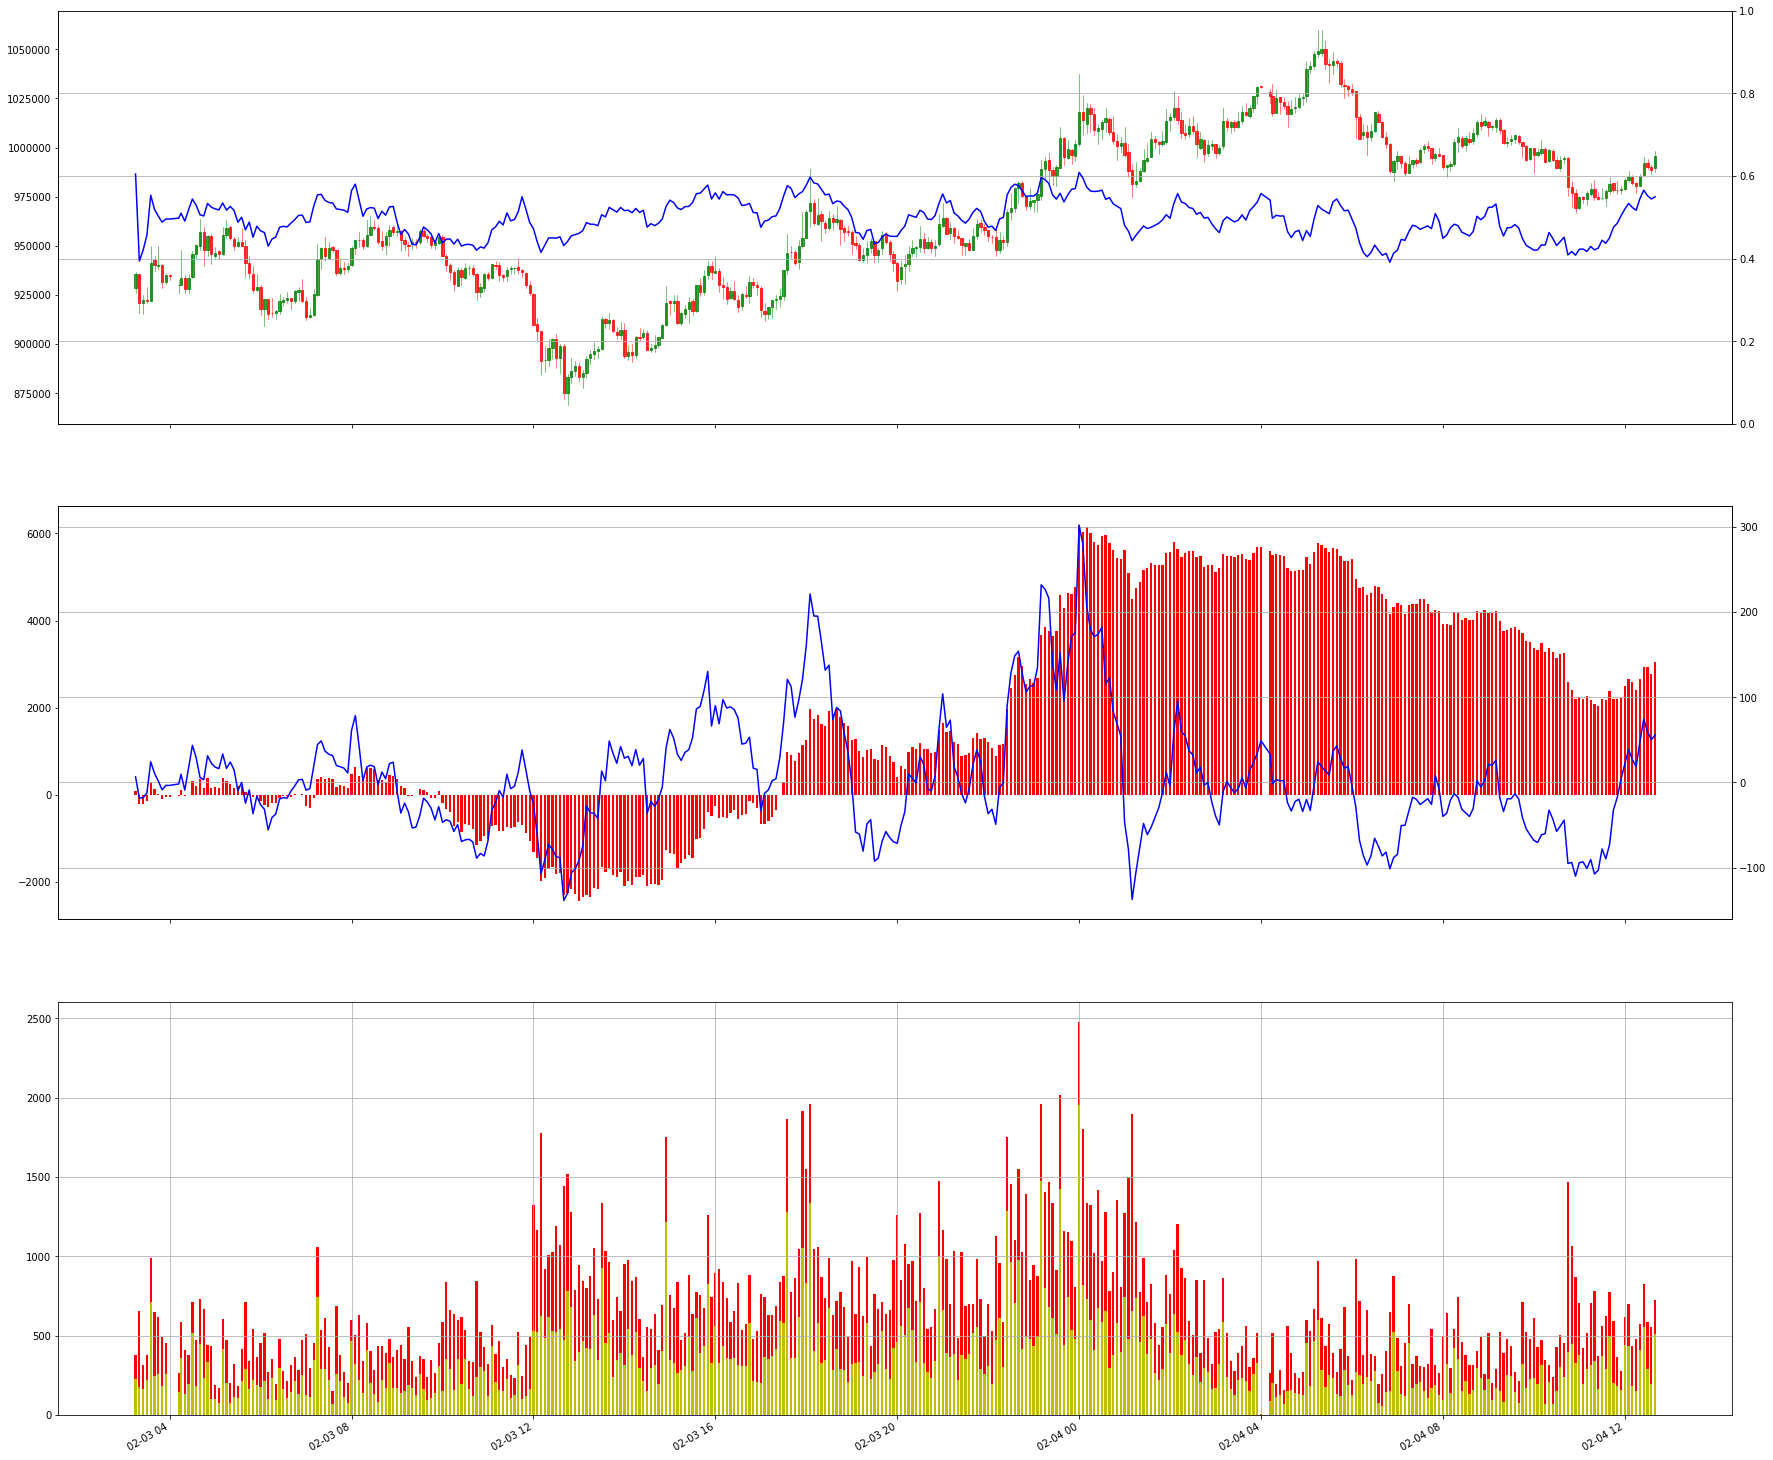

In [125]:
# 最新データ取得
update(count)

# figure_width := ローソク足チャート全体の幅 (単位:日)
# candle_width := ローソクの幅 (単位:日)
delta = date[-1] - date[0]
figure_width = delta.total_seconds()/(60*60*24)
candle_width = 0.6 * figure_width / count;

# ローソク足チャートを描く
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(311)
fig.subplots_adjust(top=0.85)
#ax.grid()
ax.set_xlim(date[0], date[-1])
mf.candlestick_ochl(ax, quote, width=candle_width, colorup='g', colordown='r', alpha=0.75)
ax2 = ax.twinx()
ax2.plot(date, volume_buy_ratio1, color='b')
ax2.set_ylim(0,1.0)
ax2.grid()
fig.autofmt_xdate()

# 出来高(買いー売り)の棒グラフを描く
#fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(312)
#ax.grid()
ax.set_xlim(date[0], date[-1])
#ax.bar(date, volume_buy, width=candle_width, color='y')
#ax.bar(date, volume_sell, bottom=volume_buy, width=candle_width, color='r')
ax.bar(date, volume_diff, width=candle_width, color='r')
ax2 = ax.twinx()
ax2.plot(date, volume_buy_avg1, color='b')
#ax2.plot(date, volume_buy_avg2, color='g')
ax2.grid()
fig.autofmt_xdate()

# 出来高の棒グラフを描く
#fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(313)
ax.grid()
#ax.set_xlim(date[0], date[-1])
ax.bar(date, volume_buy, width=candle_width, color='y')
ax.bar(date, volume_sell, bottom=volume_buy, width=candle_width, color='r')
fig.autofmt_xdate()

plt.show()
